## Ablation of top-k Guided Generation. Study of "language" and "k" influence.

We analyze how the different languages are affected by Concept Guided Generation for different levels of "k".

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from frames.nlp.datasets import load_multilingual_question_dataset
from frames.representations import FrameUnembeddingRepresentation
from frames.utils.plotting import lineplot_and_save

/home/pedro/Documents/flag-representation-hypothesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# parameters
MODEL_ID = "meta-llama/Meta-Llama-3.1-8B-Instruct"  # "hugging-quants/Meta-Llama-3.1-70B-Instruct-AWQ-INT4"
N = 1 << 8
STEPS = 1 << 4
BATCH_SIZE = 1 << 5

GUIDE = ("woman.n.01", "male.n.01")

X = "Guidance Level"
Y = "Concept Relative Projection (Guided - Unguided)"
HUE = "language"

TOPK_ABLATION_K = list(range(7, 0, -1))

In [ ]:
fur = FrameUnembeddingRepresentation.from_model_id(MODEL_ID)
print("memory cost: ", fur.model.memory_footprint >> 20, "Mb")

Token is valid (permission: read).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/pedro/.cache/huggingface/token
Login successful


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


Loaded model meta-llama/Meta-Llama-3.1-8B-Instruct
memory cost:  15316 Mb


In [5]:
dataset = load_multilingual_question_dataset(fur.data.languages).iloc[:N]
samples, langs = dataset.shape
print("Loaded dataset with", samples, "samples and", langs, "languages")

Loaded dataset with 32 samples and 8 languages


In [6]:
def gen_guided_probe(inputs, k):
    _, probe = fur.quick_generate_with_topk_guide(
        inputs,
        guide=GUIDE,
        k=k,
        steps=STEPS,
        batch_size=BATCH_SIZE,
        min_lemmas_per_synset=3,
        max_token_count=3,
    )
    return pd.DataFrame(probe.float()).melt(var_name=X, value_name=Y)

In [ ]:
df = pd.concat(
    [
        gen_guided_probe(dataset[lang].tolist(), k=k).assign(**{HUE: lang, X: k})
        for lang in dataset.columns
        for k in TOPK_ABLATION_K
    ]
)

lineplot_and_save("09_guided_generation_language_topk_ablation", df, x=X, y=Y, hue=HUE)

  0%|          | 0/1 [00:25<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.67 GiB. GPU 1 has a total capacity of 23.59 GiB of which 2.99 GiB is free. Process 3542150 has 20.33 GiB memory in use. Of the allocated memory 16.32 GiB is allocated by PyTorch, and 3.66 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

([<matplotlib.axis.YTick at 0x731d4c1e0700>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10')])

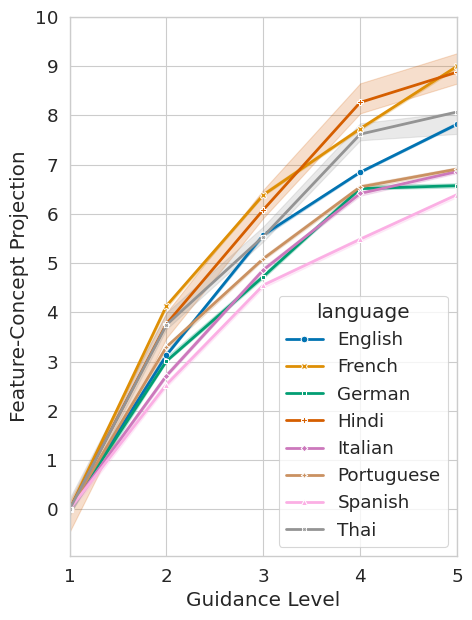

In [ ]:
values = df[df[X] == 1].groupby(HUE)[Y].mean()
df[Y] = df.apply(lambda row: row[Y] - values[row[HUE]], axis=1)

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

plt.figure(figsize=(5, 7))

sns.lineplot(
    df,
    x=X,
    y=Y,
    hue=HUE,
    style=HUE,
    markers=True,
    dashes=False,
    errorbar=("ci", 10),
    palette="colorblind",
    linewidth=2,
)
# plt.yscale("symlog")
plt.xlim(1, 5)
plt.xticks(TOPK_ABLATION_K)
plt.yticks(range(0, 11))

# lineplot_and_save("11_guided_generation_language_topk_ablation", df, x=X, y=Y, hue=HUE)

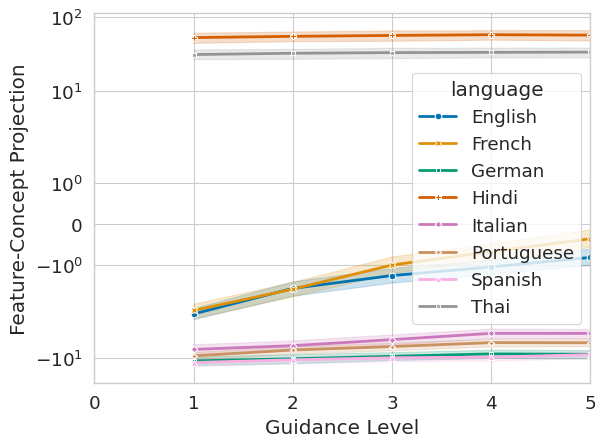

In [ ]:
plt.yscale("symlog")
lineplot_and_save("09_guided_generation_language_topk_ablation", df, x=X, y=Y, hue=HUE)